# SMS Spam Detection with Machine Learning

### Introduction

We are increasingly surrounded by smartphones, which have become an essential part of our daily lives. Given the fast-paced nature of modern communication, it is crucial not to be disturbed by irrelevant or spam messages. Such interruptions can cause frustration, anxiety, or even make us miss truly important information.

This project not only provides valuable insights into the field of Machine Learning, but also addresses a real-world problem: distinguishing the patterns of spam messages and filtering them out. By doing so, it aims to reduce unnecessary distractions and ensure that users can focus on the information that truly matters.

## Workflow 
1. Dataset Overview
    - Before starting to train a model, it is necessary to have an overview of the data distribution, the way the data are stored, and how they can be used
2. Data Preprocessing
    - Since this project deals with text data, it is crucial to preprocess and filter the words so that the models can understand them (Convert text into numerical features)
3. Modeling
    - Train baseline models (e.g., Naive Bayes, Logistic Regression)
    - Train more advanced models (e.g. XGBoost)
4. Model Evaluation
    - Compare models using accuracy, precision, recall, F1-score
    - Show confusion matrices
5. Conclusions

# Exploratory Data Analisys

First of all, the data is going to be kept into a DataFrame which allows to understand which one is the feature and which one is the label. Since the problem is handling binary classficiation and is about spam/ham detection, it is to be expected that the data would have at least the message and the label for each one

In [15]:
# import dataset

import pandas as pd

df = pd.read_csv("spam.csv", encoding='latin1')

# showing first 5 rows of the dataset
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


As expected, the first column, named `v1`, contains the labels (ground truth), and the second column appears to be the SMS text. What is particularly interesting are the last three columns, which for the first five rows are empty. The next step is to explore these columns and determine if they can be useful.


In [16]:
# how many values are missing
print(df.isnull().sum())

# the total rows of the dataset
df.shape[0]

print(df[df['Unnamed: 3'].notnull()])

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64
        v1                                                 v2  \
95    spam  Your free ringtone is waiting to be collected....   
281    ham                                \Wen u miss someone   
899   spam  Your free ringtone is waiting to be collected....   
1038   ham  Edison has rightly said, \A fool can ask more ...   
2170   ham  \CAN I PLEASE COME UP NOW IMIN TOWN.DONTMATTER...   
2255   ham      I just lov this line: \Hurt me with the truth   
3145   ham               \SHIT BABE.. THASA BIT MESSED UP.YEH   
3506   ham               Two fundamentals of cool life: \Walk   
3525   ham  \HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DE...   
4668   ham  When I was born, GOD said, \Oh No! Another IDI...   
5048   ham  Edison has rightly said, \A fool can ask more ...   
5081   ham  \HI BABE UAWAKE?FEELLIKW SHIT.JUSTFOUND OUT VI...   

                                             U

The dataset originally contains extra columns (`Unnamed: 2`, `Unnamed: 3`, `Unnamed: 4`) that are mostly empty or contain irrelevant information.  
For our spam detection task, we only need the label (`v1`) and the SMS text (`v2`).  
Therefore, we drop the unnecessary columns to simplify the dataset and avoid confusion.

In [17]:
df = df[['v1', 'v2']]

# rename the column name as the expected form
df.columns = ['label', 'text']

print(df.head())

df.label = df.label.map({'ham' : 0, 'spam' : 1})
print(df.head())


  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...


# Cleaning Text

In [18]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['text'] = df['text'].apply(clean_text)
print(df.head())
        

   label                                               text
0      0  go jurong point crazy available bugis n great ...
1      0                            ok lar joking wif u oni
2      1  free entry wkly comp win fa cup final tkts st ...
3      0                u dun say early hor u c already say
4      0        nah dont think goes usf lives around though


[nltk_data] Downloading package stopwords to /home/david/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size = 0.2, random_state= 42)

It is really important to see the distribution of the labels.
- How many of the rows are labeled as 0 `ham`, and how many as 1 `spam`

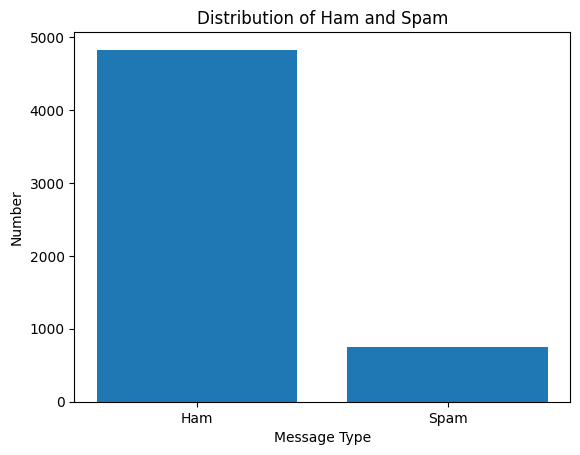

In [20]:
import matplotlib.pyplot as plt

x_val = ['Ham', 'Spam']
y_val = df.label.value_counts().values
plt.bar(x_val, y_val)
plt.xlabel("Message Type")
plt.ylabel("Number")
plt.title("Distribution of Ham and Spam")
plt.show()


It is obvious that the class distribution is imbalanced, which can negatively affect the models and cause them to overfit the majority class. So to speak
As mentioned before, a model cannot work with the words in the first place, so every word has to be transformed into a number.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    # ('smote', SMOTE(random_state=42)),
    ('model', MultinomialNB())
])

from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y = y_train
)

param_grid_nb = [
    {
        'model' : [MultinomialNB()],
        'model__alpha': [0.5, 1.0]
    }]

param_grid_xgb = [
    {
        'model' : [XGBClassifier()],
        # 'model__sample_weight'
        'model__n_estimators' : [100, 200],
        'model__max_depth' : [2, 4],
        'model__learning_rate' : [0.1, 0.5]
    }]

grid_nb = GridSearchCV(pipeline, param_grid_nb, cv = 3, scoring = 'f1')
grid_xgb = GridSearchCV(pipeline, param_grid_xgb, cv = 3, scoring = 'f1')

grid_nb.fit(X_train, y_train)
grid_xgb.fit(X_train, y_train, sample_weigth = classes_weights)


print("Best parameters NB:", grid_nb.best_params_)
print("Best parameters XGB:", grid_xgb.best_params_)

ValueError: 
All the 24 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/home/david/Proiecte/spam-detection/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/david/Proiecte/spam-detection/venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/david/Proiecte/spam-detection/venv/lib/python3.12/site-packages/imblearn/pipeline.py", line 517, in fit
    routed_params = self._check_method_params(method="fit", props=params)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/david/Proiecte/spam-detection/venv/lib/python3.12/site-packages/imblearn/pipeline.py", line 1257, in _check_method_params
    raise ValueError(
ValueError: Pipeline.fit does not accept the sample_weigth parameter. You can pass parameters to specific steps of your pipeline using the stepname__parameter format, e.g. `Pipeline.fit(X, y, logisticregression__sample_weight=sample_weight)`.


In [22]:
model_nb = grid_nb.best_estimator_
model_xgb = grid_xgb.best_estimator_

y_pred_nb = model_nb.predict(X_test)
y_pred_xgb = model_xgb.predict(X_test)


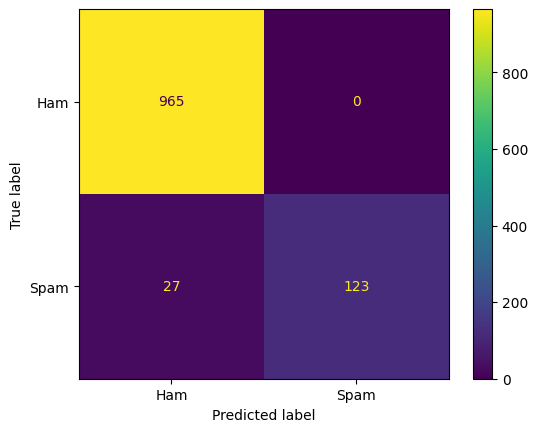

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm1 = confusion_matrix(y_test, y_pred_nb, labels = model_nb.classes_)
matrix1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['Ham','Spam'])
matrix1.plot()

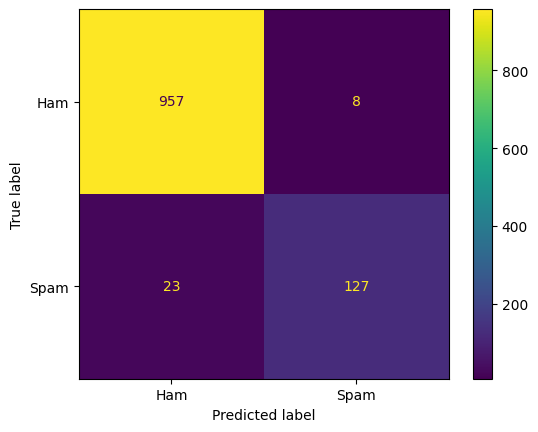

In [24]:
cm2 = confusion_matrix(y_test, y_pred_xgb, labels = model_xgb.classes_)
matrix2 = ConfusionMatrixDisplay(confusion_matrix= cm2, display_labels = ['Ham', 'Spam'])
matrix2.plot()

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_test, y_pred):
    result = {
        'accuracy' : accuracy_score(y_test, y_pred),
        'precision' : precision_score(y_test, y_pred),
        'recall_score' : recall_score(y_test, y_pred),
        'f1_score' : f1_score(y_test, y_pred)
    }
    return result
metrics_nb = evaluate_model(y_test, y_pred_nb)
metrics_xgb = evaluate_model(y_test, y_pred_xgb)

df_metrics = pd.DataFrame([metrics_nb, metrics_xgb], index=['Naive Bayes', 'XGBoost'])
df_sorted = df_metrics.sort_values(by = 'precision', ascending = False)
print(df_sorted)


             accuracy  precision  recall_score  f1_score
Naive Bayes  0.975785   1.000000      0.820000  0.901099
XGBoost      0.972197   0.940741      0.846667  0.891228


# Saving model for UI app

Now that there are already compared models, I am going to take the XGBoost model as it is the most performant one and save it as it is going to be reused in the graphical interface application which can detect whether a sms is spam or not.


In [ ]:
from joblib import dump
dump(grid_nb, "model_trained.joblib")

['model_trained.joblib']